Copyright 2019 Carsten Blank

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
from qiskit import QuantumCircuit
%load_ext autoreload

In [2]:
# Uncomment if you have not set up the PYTHONPATH to point to the code!
# import sys
# import os 
# sys.path.append("{}/../lib_paper".format(os.getcwd()))
# sys.path.append("{}/../../experiment_results".format(os.getcwd()))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from lib_experimental_utils import FinishedExperiment

In [3]:
%autoreload 2
%aimport lib_experimental_utils

## Used int he paper:
* exp_sim_regular_noise_job_20190324T102757Z_archive
* exp_sim_regular_20190626T152158Z
Use this for regular:
* exp_sim_regular_20190626T152158Z
* exp_sim_regular_20190626T152154Z (ibmqx2)


Recent:
* exp_sim_regular_20190622T111845Z (ibmqx2)
* exp_sim_regular_20190622T111850Z
* exp_sim_regular_20190622T144425Z (ibmqx2)
* exp_sim_regular_20190622T144428Z
## Hadamard
* exp_sim_hadamard_20190326T211320Z_archive
* exp_sim_hadamard_20190622T203506Z (ibmqx2)
* exp_sim_hadamard_20190622T203511Z

In [4]:
import exp_sim_regular_20190929T114806Z as loaded
experiment = FinishedExperiment.from_dict(loaded.result['experiment'])
simulation = FinishedExperiment.from_dict(loaded.result['simulation'])
experiment.backend_name

'ibmq_ourense'

(-0.55, 0.55)

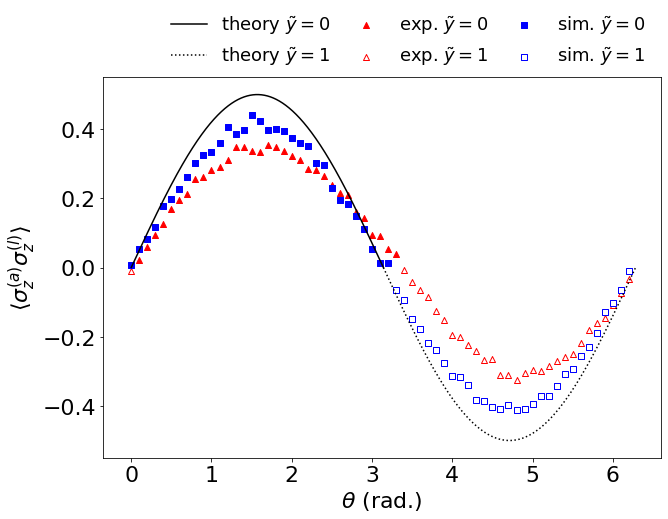

In [5]:
w_1 = 0.5
w_2 = 1 - w_1
theta = np.arange(0, 2*np.pi, 0.1)
theory_classification = w_1 * np.sin(theta/2 + np.pi/4)**2 - w_2 * np.cos(theta/2 + np.pi/4)**2
def theory_expectation(w_1, w_2):
    def inner(x):
        return w_1 * np.sin(x/2 + np.pi/4)**2 - w_2 * np.cos(x/2 + np.pi/4)**2
    return inner

simulation.set_theta(theta)
experiment.set_theta(theta)

experiment.show_plot(compare_classification=simulation.get_classification(), 
                     classification_label='exp.', 
                     compare_classification_label='sim.')
finer_theta = np.arange(0, 2*np.pi, 1e-3)
t_cl = [theory_expectation(w_1, w_2)(t) for t in finer_theta]
plt.plot([xx for xx, p in zip(finer_theta, t_cl) if p > 1e-6],
         #[p*0.1736 for p in t_cl if p > 1e-6],
         [p for p in t_cl if p > 1e-6],
         c="black",
         # label='$0.17 \\cdot$ theory $\\tilde{y} = 0$',
         label='theory $\\tilde{y} = 0$',
         linestyle='-')
plt.plot([xx for xx, p in zip(finer_theta, t_cl) if p < -1e-6],
         #'[p*0.1736 for p in t_cl if p < -1e-6],
         [p for p in t_cl if p < -1e-6],
         c="black",
         # label='$0.17 \\cdot$ theory $\\tilde{y} = 1$',
         label='theory $\\tilde{y} = 1$',
         linestyle=':')
plt.legend(fontsize=18, ncol=3, columnspacing=1, mode='expend', bbox_to_anchor=(1.0,1.21), frameon=False)
plt.ylim((-.55,.55))

# Uncomment to save
# plt.savefig("../images/{}_all_together.png".format(loaded.__name__), bbox_inches='tight')
# plt.savefig("../images/{}_all_together.pdf".format(loaded.__name__), bbox_inches='tight')

In [6]:
simulation.parameters.get('device_properties')

({'backend_name': 'ibmq_ourense',
  'backend_version': '1.0.0',
  'gates': [{'gate': 'id',
    'name': 'id_0',
    'parameters': [{'date': '2019-09-29T07:55:19+00:00',
      'name': 'gate_error',
      'unit': '',
      'value': 0.0003184529476803157},
     {'date': '2019-09-29T09:16:40+00:00',
      'name': 'gate_length',
      'unit': 'ns',
      'value': 35.55555555555556}],
    'qubits': [0]},
   {'gate': 'u1',
    'name': 'u1_0',
    'parameters': [{'date': '2019-09-29T07:55:19+00:00',
      'name': 'gate_error',
      'unit': '',
      'value': 0.0},
     {'date': '2019-09-29T09:16:40+00:00',
      'name': 'gate_length',
      'unit': 'ns',
      'value': 0.0}],
    'qubits': [0]},
   {'gate': 'u2',
    'name': 'u2_0',
    'parameters': [{'date': '2019-09-29T07:55:19+00:00',
      'name': 'gate_error',
      'unit': '',
      'value': 0.0003184529476803157},
     {'date': '2019-09-29T09:16:40+00:00',
      'name': 'gate_length',
      'unit': 'ns',
      'value': 35.5555555555555

In [10]:
import qiskit.assembler
qcs, _, _ = qiskit.assembler.disassemble(experiment.qobj)
qc = qcs[8]  # type: QuantumCircuit
print(qc.draw(output='mpl'))

Figure(1661.52x806.68)


In [11]:
from scipy.optimize import minimize

def mse(classification, theta):
    classification = np.asarray(classification)
    def inner(x):
        a, vartheta, w_1 = x
        reference = np.asarray([
            a*theory_expectation(w_1=w_1, w_2=1 - w_1)(t - vartheta) for t in theta
        ])
        return np.sqrt(sum(np.power(classification - reference, 2)))
    return inner

fun = mse(experiment.get_classification(), theta)
x_0 = [1.0, 0, 0]
result = minimize(fun, x_0)

[a, vartheta, w_1] = result.x
a, vartheta/np.pi, w_1

(0.6515240666279911, 0.03908348174502089, 0.5414319425830694)